In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw6.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science
## Homework 6: Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2pt">



In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

### Import Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Decision Tree**](#part1)


- [**Question 2: Bagging**](#part2) 


- [**Question 3: Random Forests**](#part3) 


- [**Question 4: Boosting**](#part4) 


<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)


### Higgs boson discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. 

### Data description

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

### Loading the data

Run the following cell to load the data. Do not modify this code. We need to ensure everyone has the exact same arrays for this homework.

**Note:** If you have issues passing some of the test cases it may be due to your version of SKLearn. Try running your notebook on the OneDemand Jupyter service linked from Canvas where everyone has access to a standardized Python environment.

In [4]:
# RUN THIS CELL
# DO NOT MODIFY THIS CODE

data_train = pd.read_csv("data/Higgs_train.csv")
data_test = pd.read_csv("data/Higgs_test.csv")

print(
    f"Our data contains {len(data_train):,} training samples "
    f"and {len(data_test):,} test samples.\n"
)

print("TRAINING DATA INFORMATION:\n")
data_train.info()

print("\nTRAINING DATA HEAD:")
display(data_train.head())

print("\nTRAINING DATA SUMMARY STATISTICS:")
display(data_train.describe())

# Split dataframe into X and y numpy arrays
X_train = data_train.iloc[:, data_train.columns != "class"].values
y_train = data_train["class"].values
X_test = data_test.iloc[:, data_test.columns != "class"].values
y_test = data_test["class"].values

Our data contains 5,000 training samples and 5,000 test samples.

TRAINING DATA INFORMATION:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lepton pT                 5000 non-null   float64
 1   lepton eta                5000 non-null   float64
 2   lepton phi                5000 non-null   float64
 3   missing energy magnitude  5000 non-null   float64
 4   missing energy phi        5000 non-null   float64
 5   jet 1 pt                  5000 non-null   float64
 6   jet 1 eta                 5000 non-null   float64
 7   jet 1 phi                 5000 non-null   float64
 8   jet 1 b-tag               5000 non-null   float64
 9   jet 2 pt                  5000 non-null   float64
 10  jet 2 eta                 5000 non-null   float64
 11  jet 2 phi                 5000 non-null   float64
 12  jet 2 b-tag             

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0



TRAINING DATA SUMMARY STATISTICS:


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


<a id="part1"></a>

## <div class='exercise'>Question 1: Decision Tree</div> 
    
[Return to contents](#contents)
    

<div class='exercise-r'>

**1.1** In this problem, we will observe how both tree-depth and cross-validation affect our ability to accurately model data. Specifically, for each tree depth from 1 to 20 (inclusive):

- Fit a decision tree to the entire **training** set. Set `random_state=0`.

- Evaluate on the entire **training** set (i.e., `.score(...)`), while storing the scores in a variable named `train_scores`.

- Perform 5-fold cross-validation with the entire **training** set using [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Store the mean validation score and the validation standard deviation  in variables named `cvmeans` and `cvstds` respectively.

**IMPORTANT:** Throughout this assignment, you should set `random_state=0` in any model that takes such an argument to ensure reproducible results.
</div>

In [5]:

first_depth = 1   
final_depth = 20
step = 1

train_scores = []
cvmeans = []
cvstds = []



for depth in range(first_depth, final_depth+1,step):
    dt = DecisionTreeClassifier(max_depth=depth, random_state = 0)
    dt.fit(X_train, y_train)
    train_score = dt.score(X_train, y_train)
    train_scores.append(train_score)

    #5-fold cross-validation every iteration
    cv_scores = cross_val_score(dt, X_train, y_train, cv = 5,n_jobs = -1)
    cvmeans.append(cv_scores.mean())
    cvstds.append(cv_scores.std())


In [6]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>
    
**1.2** Now that we have `train_scores`, `cvmeans`, and `cvstds`, let's plot them. Generate 2 plots, both showing (a) the non-cross-validation training scores, (b) the mean validation scores, and (c) a shaded region that illustrates the +/-2 standard deviation validation bounds for each tree depth. The content and formatting of these 2 plots should be identical, EXCEPT in one plot set the limits on the y-axis to focus on the validation performance. Remember to label and title each plot appropropriately.

**HINT:** You can use `plt.fill_between(...)` to easily generate the shaded region in your plots.

</div>

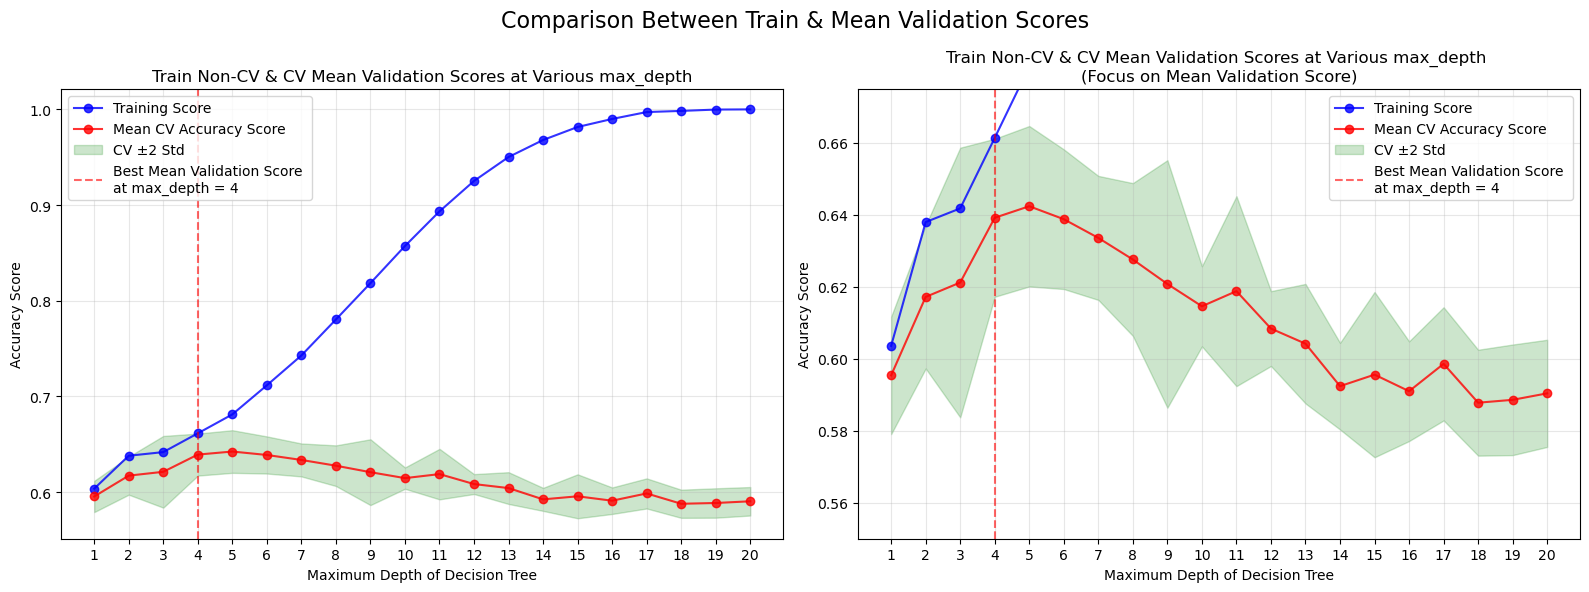

In [7]:


train_scores = np.array(train_scores)
cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)
x_axis = np.arange(1, 21)
max_depth = x_axis  

# Calculate the upper and lower bounds for the shaded region
upper = cvmeans + 2 * cvstds
lower = cvmeans - 2 * cvstds


fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax = ax.ravel()

# Full Score Range plot
ax[0].plot(x_axis, train_scores, 'b-', marker='o', label='Training Score', alpha=0.8)
ax[0].plot(x_axis, cvmeans, 'r-', marker='o', label='Mean CV Accuracy Score', alpha=0.8)
ax[0].fill_between(x_axis, lower, upper, color='g', alpha=0.2, label='CV ±2 Std')
ax[0].axvline(max_depth[np.argmax(cvmeans) - 1], color='red', alpha=0.6, linestyle='--',
              label=f'Best Mean Validation Score \nat max_depth = {max_depth[np.argmax(cvmeans) - 1]}')
ax[0].set_xticks(x_axis) 
ax[0].legend(loc='upper left')
ax[0].set_title('Train Non-CV & CV Mean Validation Scores at Various max_depth', fontsize=12)
ax[0].set_xlabel('Maximum Depth of Decision Tree', fontsize=10)
ax[0].set_ylabel('Accuracy Score', fontsize=10)
ax[0].grid(alpha=0.3)

# Focused Validation Range plot
ax[1].plot(x_axis, train_scores, 'b-', marker='o', label='Training Score', alpha=0.8)
ax[1].plot(x_axis, cvmeans, 'r-', marker='o', label='Mean CV Accuracy Score', alpha=0.8)
ax[1].fill_between(x_axis, lower, upper, color='g', alpha=0.2, label='CV ±2 Std')
ax[1].axvline(max_depth[np.argmax(cvmeans) - 1], color='red', alpha=0.6, linestyle='--',
              label=f'Best Mean Validation Score \nat max_depth = {max_depth[np.argmax(cvmeans) - 1]}')
ax[1].set_xticks(x_axis)  
ax[1].set_ylim(0.55, 0.675)
ax[1].legend(loc='upper right')
ax[1].set_title('Train Non-CV & CV Mean Validation Scores at Various max_depth \n(Focus on Mean Validation Score)', fontsize=12)
ax[1].set_xlabel('Maximum Depth of Decision Tree', fontsize=10)
ax[1].set_ylabel('Accuracy Score', fontsize=10)
ax[1].grid(alpha=0.3)

fig.suptitle('Comparison Between Train & Mean Validation Scores', fontsize=16)
plt.tight_layout()



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.3** Using the cross-validation experiments from above, select a depth you deem most appropriate for using on future, unseen data, store it in `best_cv_depth`, and **justify your choice**. Then, using this depth, fit a new decision tree on the entire training data and store the train and test accuracies in `best_cv_tree_train_score` and `best_cv_tree_test_score`, respectively, which we will refer to in later questions.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

**Observation**

- From the graph evaluating training and validation scores at various depths, we observe that the highest mean validation accuracy is achieved at a maximum depth of 5. However, at this depth, the gap between training and validation scores starts to widen, indicating the onset of overfitting. As the maximum depth increases, the model becomes more complex, overfitting.

- Notably, the difference in validation accuracy between depths 4 (0.6392) and 5 (0.6424) is minimal, with a delta of only 0.0032. Depth 4 offers a simpler model with less overfitting, making it a better choice. Consequently, we select depth 4 for fitting a new decision tree on the entire training data.

- Although the decision tree trained with depth 4 yielded better test accuracy than depth 5, this is not the primary reason for selecting depth 4. The decision is based on reducing overfitting and maintaining simplicity.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [8]:
#Determine the best cv depth ,best_cv_tree_train_score,best_cv_tree_test_score 
best_cv_depth = max_depth[np.argmax(cvmeans)] -1 

dt1 = DecisionTreeClassifier(random_state = 0, max_depth=best_cv_depth).fit(X_train, y_train)
best_cv_tree_train_score = dt1.score(X_train, y_train)
best_cv_tree_test_score = dt1.score(X_test, y_test)


# displaying the validation accuracy at depth 4 and depth 5
display(pd.DataFrame(zip(max_depth, cvmeans), 
                     columns = ['max_depth','validation accuracy']).sort_values(by = 'validation accuracy', 
                                                                               ascending = False).head(2))

,max_depth,validation accuracy
4,5,0.6424
3,4,0.6392


In [9]:
# print model results summary
print(
    "The tree of max-depth {} trained on the "
    "full training set, achieves the following accuracy scores:"
    "\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}".format(
        best_cv_depth,
        best_cv_tree_train_score,
        best_cv_tree_test_score,
    )
)

The tree of max-depth 4 trained on the full training set, achieves the following accuracy scores:

	train	0.6614
	TEST	0.6510


<!-- END QUESTION -->

<a id="part2"></a>

## <div class='exercise'>Question 2: Bagging</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.1** Based on your results from [Question 1](#part1solutions), choose a tree depth that WILL overfit the training set. What evidence leads you to believe that this depth overfits? Assign your choice to a variable named `tree_depth`. (You may want to explore different settings for this value in the problems below. However, be certain that your final choice and rationale is based on your results from Question 1.)

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Observing from the graph, we can see strong signs of overfitting at depth=20. 

At depth = 20, there is a significant gap between the training score and CV Mean.

This substantial discrepancy between training and validation performance is a strong indicator of overfitting.

Additionally, we can see that beyond depth=15, the training score continues to rise while the CV Mean remains low and slightly decreases.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [10]:
# set overfitting tree_depth based on provided rationale 
tree_depth = 20

<!-- END QUESTION -->

<div class='exercise-r'>

**2.2** Here we will use the `tree_depth` chosen in Question 2.1 to generate 55 boostrapped sets of decision tree predictions for both the training and test data. To accomplish this:

- **Using a random seed of 0**, call the provided `bagger` function to return your bootstrapped results.
- Store your returned results as: 
  1. `bagging_train_df`: a dataframe containing your training data predictions (see the "required dataframe structure" below)
  2. `bagging_test_df`: a dataframe containing your test data predictions
  3. `bagging_models_list`: a list containing your 55 fitted model objects (i.e. fitted estimators)
- Finally, display the heads of both dataframes.

**NOTE:** There is no need to do anything with your `bagging_models_list` list yet. It will not be used until later in [Question 3.2](#part3).

**DATAFRAME STRUCTURE:** The training and test prediction results of your bootstraps are returned by the `bagger` function as dataframes formatted like the example shown below. Each row represents one observation (from either the training or test set depending on the dataframe), and each column represents one bootstrapped result. The values stored in the dataframe are the bootstrapped predictions for each observation as illustrated below.

An example of the `bagging_train_df` and `bagging_test_df` dataframes would be:

|     |bootstrap model 1|bootstrap model 2|...|bootstrap model 55|  
| --- | --- | --- | --- | --- |
|0| 0 | 1|... |0|
|1| 1| 1|... |0|
|2| 0| 0|... |1|
|...| ...| ...|... |... |
| $n$-1 | 0| 0|... |1|

</div>

In [11]:
def bagger(
    n_trees: int,
    tree_depth: int,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    random_seed: int = 0,
) -> (pd.DataFrame, pd.DataFrame, list):
    """Generate boostrapped DecisionTreeClassifier predictions
    
    Function fits bootstrapped DecisionTreeClassifier models
    and returns training and test predictions for each of those
    bootstrapped models, along with the fitted model objects as
    described in Question 2.2 question text.
    
    :param n_trees: int, number of bootstrapped decision trees
    :param tree_depth: int, maximum tree depth
    :param X_train: np.ndarray, training X observations
    :param y_train: np.ndarray, training y observations
    :param X_test: np.ndarray, test X observations
    :param random_seed: int, random seed used to set np.random.seed
                        to ensure replicable results (default=0)
    
    :returns: (pd.DataFrame, pd.DataFrame, list), tuple containing 3
              objects, (1) bagging_train_df dataframe
              as described in Q2.2 question text, (2) bagging_test_df
              dataframe as described in Q2.2, and (3) bagging_models_list
              containing every trained DecisionTreeClassifier model
              object (i.e. estimator), one estimator for each bootstrap
              (you will need this list later in Q3.2)
    """
    
    # set random seed for replicable results
    np.random.seed(random_seed)
    
    # instantiate arrays and list for storing results
    bagging_train = np.zeros((X_train.shape[0], n_trees)).astype(int)
    bagging_test = np.zeros((X_test.shape[0], n_trees)).astype(int)

    bagging_models_list = []

    # perform n bootstraps
    for i in range(n_trees):
        # generate bootstrapped model
        bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
        fitted_model = DecisionTreeClassifier(
            max_depth=tree_depth,
            random_state=0
        ).fit(bootstrapped_X, bootstrapped_y)
        bagging_models_list.append(fitted_model)

        # predict on full training and test sets and store
        # results to arrays
        bagging_train[:,i] = fitted_model.predict(X_train)
        bagging_test[:,i] = fitted_model.predict(X_test)
    
    # convert arrays to pandas dataframes as required
    bagging_train_df = pd.DataFrame(
        bagging_train[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    bagging_test_df = pd.DataFrame(
        bagging_test[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    
    return bagging_train_df, bagging_test_df, bagging_models_list
    

In [12]:
# specify number of required bootrapped trees
n_trees = 55 

In [13]:
# generate predictions using bagger function
bagging_train_df, bagging_test_df, bagging_models_list = bagger(
    n_trees= n_trees,
    tree_depth = tree_depth,
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    random_seed = 0
)

In [14]:
# display resulting dataframe heads
display(bagging_train_df.head())
display(bagging_test_df.head())

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37,model38,model39,model40,model41,model42,model43,model44,model45,model46,model47,model48,model49,model50,model51,model52,model53,model54
0,1,1,1,1,1,0,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
1,0,1,1,1,1,0,1,1,0,0,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,1,0,1,1,1,1,1,0,1,1,0,1,1,1,0,1,1,0,0,1,1,1,0,0,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1
3,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,1,1,1,0,1,0,1,0,1,1,1,1
4,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0


,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37,model38,model39,model40,model41,model42,model43,model44,model45,model46,model47,model48,model49,model50,model51,model52,model53,model54
0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,1,1,1,0,0,0,1,1,1,0,1,0,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,0,1,0,0
1,0,0,1,0,0,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,1,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0
2,1,0,1,1,1,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,1,0,1,1,1,1,0,0,0,0,1,0,0,0,1,1,1,1,1,0,1,1,0,1,0,0,1,1,1,1,1,0,1,1
3,1,1,1,0,1,0,0,1,1,0,1,0,1,1,0,1,1,0,1,0,1,1,0,1,1,0,1,1,0,1,1,1,1,1,0,1,1,1,0,0,1,0,0,1,1,0,1,0,1,1,1,1,1,0,1
4,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,1,0,0,1,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,1,1,0


In [15]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<div class='exercise-r'>

**2.3**  Aggregate all 55 bootstrapped models to get a combined prediction for each training and test observation (i.e. predict a `1` if, and only if, a majority of the models predict that observation to be from class 1). Assign the bagging train and test accuracies to variables named `bagging_accuracy_train` and `bagging_accuracy_test`.

**HINT:** You can use `np.mean(...)` to easily test for majority. If a majority of models vote 1, consider what that implies about the mean.

</div>

In [16]:
# evaluate accuracy on our bagged prediction results

train_pred = (bagging_train_df.mean(axis=1) > 0.5).astype(int)
test_pred = (bagging_test_df.mean(axis=1) > 0.5).astype(int)

bagging_accuracy_train = (train_pred == y_train).mean()
bagging_accuracy_test = (test_pred == y_test).mean()


In [17]:
# print summary of results
print(
    f"Bagging {n_trees} trees of depth-{tree_depth} achieves "
    f"the following accuracy scores:\n\n\ttrain\t"
    f"{bagging_accuracy_train:.4f}\n\tTEST\t"
    f"{bagging_accuracy_test:.4f}\n"
)
print(
    f"Our prior single depth-{best_cv_depth} tree achieved a "
    f"TEST score of {best_cv_tree_test_score:.4f}."
)

Bagging 55 trees of depth-20 achieves the following accuracy scores:

	train	0.9996
	TEST	0.6786

Our prior single depth-4 tree achieved a TEST score of 0.6510.


In [18]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions(...)` function provided below to get the model's accuracy score when using only $j$ of the bootstrapped models, where $j \in [1, 2, 3, ..., 55]$. Using the `tree_depth` chosen in Question 2.1, make a plot that illustrates the accuracy on the training set and test set at each number of bootstraps (varying $j$ from 1 to 55). Please see the `running_predictions` signature and docstring regarding the use of the function. You should be able to use your `bagger`-generated dataframes from Q2.2 as an input to this function.

On your plot, in addition to the training and test accuracies at each value $j$, also include horizontal lines for two baseline comparisons:

1. The test accuracy of the best model from [Question 1](#part1solutions);
2. The test accuracy of a single decision tree with the overfit `tree_depth` you chose in Question 2.1, trained on the full training set.


**Note**: We are permitted to peek at the test scores here because we just want to understand the general behavior of bagging as we add estimators. We are not using the test scores to perform model selection.

</div>

In [19]:
# RUN THIS CELL
# DO NOT MODIFY THIS CODE

def running_predictions(
    bagger_results_df: pd.DataFrame,
    targets: np.ndarray,
) -> pd.Series:
    """Generates running accuracy of intermediate bootstraps when bagging 
    
    Generates a series of accuracy scores calculated using the
    running predictions of each additional bootstrapped model
    generated using the Question 2.2 `bagger` function. For example,
    the first accuracy in the series represents the predictive
    accuracy of just the first bootstrapped model. The second accuracy
    reflects the bagged accuracy of the first 2 bootstrapped models. The
    j-th accuracy reflects the bagged accuracy of the first j
    bootstrapped models.
    
    :param bagger_results_df: pd.DataFrame, a bagging results dataframe
                              (either train or test) output from the Q2.2
                              `bagger` function
    :param targets: np.ndarray, 1-dimensional array of true class labels
                    for either train or test observations (i.e y_train or
                    y_test, whichever corresponds to the inputted
                    bagger_results_df)             
    :returns: pd.Series, a series of values showing the accuracy of
              using the initial j trees to predict the targets for each
              value of j bootstrapped models
    """
    # verify that input data objects meet the requirements specified
    # in the docstring
    assert type(bagger_results_df)==pd.core.frame.DataFrame, (
        "bagger_results_df input must be a pd.DataFrame"
    )
    assert type(targets)==np.ndarray, (
        "targets input must be an np.ndarray"
    )
    assert targets.ndim==1, (
        "targets input np.ndarray must be one-dimensional"
    )
    
    # identify the number of bootstrapped trees in inputted bagger df
    n_trees = bagger_results_df.shape[1]
    
    # calculate the running percentage of models voting 1 as each
    # additional model is considered
    running_percent_1s = (
        np.cumsum(bagger_results_df, axis=1)/np.arange(1,n_trees+1)
    )
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    # calculate and return final accuracies
    return np.mean(running_correctnesss, axis=0)


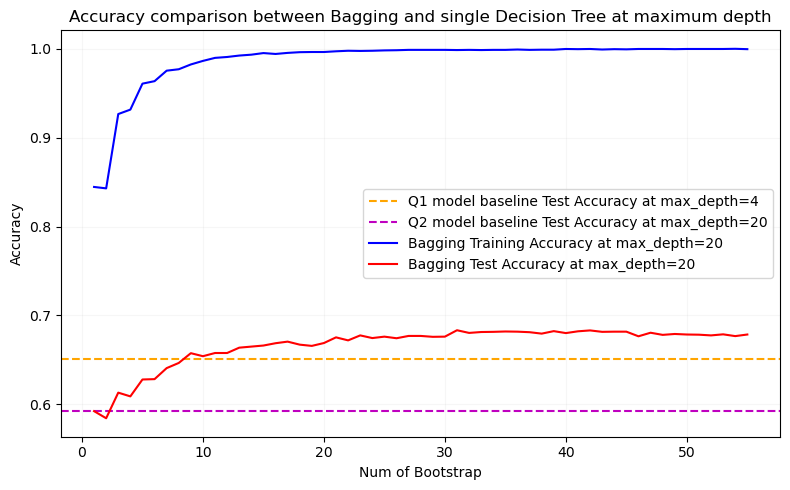

In [20]:
# Use depth = best_cv_depth (4) we got from q1 
q1_tree = DecisionTreeClassifier(max_depth = best_cv_depth , random_state=0)  
q1_tree.fit(X_train, y_train)
q1_accuracy = q1_tree.score(X_test, y_test) 


# use depth = tree_depth (20) from q2
q2_tree = DecisionTreeClassifier(max_depth=tree_depth, random_state=0)
q2_tree.fit(X_train, y_train)
q2_accuracy = q2_tree.score(X_test, y_test)



plt.figure(figsize=(8, 5))


# horizontal lines for two baseline comparisons
plt.axhline(y=q1_accuracy, color='orange', linestyle='--', 
            label='Q1 model baseline Test Accuracy at max_depth=4')
plt.axhline(y=q2_accuracy, color='m', linestyle='--', 
            label='Q2 model baseline Test Accuracy at max_depth=20')


# Use the `running_predictions(...)` function provided below to get the model's accuracy score when using only $j$ of the bootstrapped models,
#  where $j \in [1, 2, 3, ..., 55]$.
train_acc = running_predictions(bagging_train_df, y_train)
test_acc = running_predictions(bagging_test_df, y_test)
plt.plot(range(1, 56), train_acc, 'b-', label='Bagging Training Accuracy at max_depth=20')
plt.plot(range(1, 56), test_acc, 'r-', label='Bagging Test Accuracy at max_depth=20')


plt.xlabel('Num of Bootstrap')
plt.ylabel('Accuracy')
plt.title('Accuracy comparison between Bagging and single Decision Tree at maximum depth')
plt.legend()
plt.grid(True, alpha=0.1)
plt.tight_layout()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain what you see in terms of the differences between how bagging and limiting tree depth work to control overfitting.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_We can see two methods to control overfitting: limiting tree depth and bagging. Limiting tree depth (Q1) creates simpler trees, while bagging uses multiple deep trees and combines their predictions._

_Bagging improves the test accuracy from 0.59 to 0.68, performing better than both the deep single tree (Q2) and the shallow tree (Q1). This shows that bagging effectively reduces overfitting while keeping the model's ability to learn complex patterns._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<a id="part3"></a>

## <div class='exercise'>Question 3: Random Forests</div> 

[Return to contents](#contents)

<div class='exercise-r'>

**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees you used in Question 2.2, and set the maximum number of features to use when looking for the best split to be the square root of the total number of features. Evaluate classifier's accuracy on the training and test sets and store them in `random_forest_train_score` and `random_forest_test_score`.

</div>

In [21]:
# Fit a `RandomForestClassifier` to the original `X_train` data
#  using the same tree depth and number of trees you used in Question 2.2,
rf_classifier = RandomForestClassifier(max_depth=tree_depth,
                                        n_estimators=55,
                                        max_features='sqrt',
                                        n_jobs=-1,
                                        random_state =  0 )

# Fit to the training data
rf_classifier.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, n_estimators=55, n_jobs=-1, random_state=0)

In [22]:
# evaluate results
# Evaluate classifier's accuracy on the training and test sets
# store them in `random_forest_train_score` and `random_forest_test_score`.
random_forest_train_score = rf_classifier.score(X_train, y_train)
random_forest_test_score = rf_classifier.score(X_test, y_test)

print(f'Random Forest Training Score : {random_forest_train_score:.3f}')
print(f'Random Forest Test Score : {random_forest_test_score:.3f}')


Random Forest Training Score : 1.000
Random Forest Test Score : 0.692


In [23]:
# print results summary
print(
    "The random forest of depth-{} and {} trees achieves the "
    "following accuracy scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        tree_depth,
        n_trees,
        random_forest_train_score,
        random_forest_test_score,
    )
)

The random forest of depth-20 and 55 trees achieves the following accuracy scores:

	train	1.0000
	TEST	0.6922


In [24]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.2** Among all of the decision trees you fit in the bagging process (i.e. each of the fitted model objects stored in `bagging_models_list`), how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? Assign the answers to these questions to two pandas Dataframes called `top_predictors_bagging` and `top_predictors_rf`, and display them.

What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs. random forest?

**HINT:** A decision tree's top feature is stored as `.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.
    
**IMPORTANT:** As always, your output should be easy to interpret. In this context that means construcing your DataFrames with the care, assigning appropriate column names and/or index values to best convey to the reader what the output represents.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_The difference in top predictors between Bagging and Random Forest arises from the way Random Forest incorporates randomness during training. 
In Bagging, all features are considered for each split, leading to repeated selection of the dominant feature (m_bb). In contrast, Random Forest restricts the features available at each split, ensuring greater diversity among the decision trees._

_This increased diversity in Random Forest results in a more generalisable model, reducing overfitting and enhancing accuracy on unseen data compared to Bagging, which may suffer from over-reliance on a single feature._

_In terms of accuracy, the Random Forest (depth-20, 55 trees) achieves perfect accuracy on the training set (1.0000) and a test accuracy of 0.6922, while Bagging with 55 trees of the same depth achieves a slightly lower training accuracy (0.9996) and a test accuracy of 0.6786._

_The improvement in test accuracy with Random Forest can be attributed to the additional randomness introduced during feature selection, which enhances generalisation. Consequently, Random Forest tends to outperform Bagging in terms of accuracy on unseen data._


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [25]:
top_features_bagging = {}

#for the baggin model
for model in bagging_models_list:
    top_feature_index = model.tree_.feature[0] #first top node
    top_feature_name = data_train.columns[top_feature_index]
    if top_feature_name in top_features_bagging:
        top_features_bagging[top_feature_name] += 1
    else:
        top_features_bagging[top_feature_name] = 1

#sort the features (bagging )
top_predictors_bagging = pd.DataFrame(list(top_features_bagging.items()), 
                                      columns=['Feature', 'Count']).sort_values(by='Count', ascending=False)

print("Top Predictors in Bagging Models:")
print(top_predictors_bagging)



Top Predictors in Bagging Models:
  Feature  Count
0    m_bb     55


In [26]:
top_features_rf = {}

for estimator in rf_classifier.estimators_:
    top_feature_index = estimator.tree_.feature[0]
    top_feature_name = data_train.columns[top_feature_index]
    if top_feature_name in top_features_rf:
        top_features_rf[top_feature_name] += 1
    else:
        top_features_rf[top_feature_name] = 1

top_predictors_rf = pd.DataFrame(list(top_features_rf.items()), columns=['Feature', 'Count']).sort_values(by='Count', ascending=False)

print("\nTop Predictors in Random Forest:")
print(top_predictors_rf)


Top Predictors in Random Forest:
                     Feature  Count
1                       m_bb     10
0                     m_wwbb      9
3                      m_wbb      8
7                      m_jjj      7
2                      m_jlv      6
5                  lepton pT      4
8   missing energy magnitude      2
9                jet 2 b-tag      2
4                  jet 2 eta      1
6                  jet 4 phi      1
10                 jet 2 phi      1
11                 jet 1 phi      1
12                  jet 4 pt      1
13                  jet 1 pt      1
14                lepton eta      1


In [27]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.3**: Make a Pandas DataFrame (following the expected structure shown below) of the training and test accuracy for the following models and name it `results_df`:

1. Single tree with the best depth chosen by cross-validation (from Question 1)
2. A single overfit tree trained on all data (from Question 2, using the depth you chose there)
3. Bagging 55 such trees (from Question 2)
4. A random forest of 55 such trees (from Question 3.1)

Display your `results_df` dataframe and answer: What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance tradeoff.

**NOTE:** This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.

The expected structure for `results_df` is:  

| classifier | training accuracy | test accuracy |
| --- |  --- | --- |
| single depth-$i$ tree chosen by CV | ... | ... |
| single overfit depth-$k$ tree | ... | ... |
| bagging 55 depth-$k$ trees | ... | ... |
| random forest of 55 depth-$k$ trees | ... | ... |

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_The performance of each model on the training and test sets shows how the bias-variance tradeoff plays out for each approach._

_The single depth-4 tree chosen by CV had a training accuracy of 0.6614 and a test accuracy of 0.6510, which makes sense because the model is simple, so it has high bias and some underfitting, but it doesn’t overfit the data. On the other hand, when the depth was increased to 20 for a single tree, the training accuracy became 1.0000, but the test accuracy dropped to 0.5926, showing severe overfitting. This happened because the model was too complex, leading to low bias but very high variance._

_Bagging with 55 depth-20 trees improved the test accuracy to 0.6786 and still had a high training accuracy of 0.9996. This makes sense because bagging reduces variance by averaging predictions from multiple models, but since the trees are still very deep, some overfitting remains._ 

_Random Forest performed the best with a test accuracy of 0.6922 and a training accuracy of 1.0000. This is because Random Forest introduces extra randomness by using a subset of predictors at each split, which helps reduce overfitting even further and balances the bias-variance tradeoff better._

_Overall, the results make sense: simpler models like the depth-4 tree have high bias and underfit, while more complex models like the depth-20 single tree have high variance and overfit, and ensemble methods like bagging and Random Forest help reduce variance and improve generalization._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [28]:
#Update
# for q2 overfitting model
overfit_tree_depth_k = DecisionTreeClassifier(max_depth=tree_depth, random_state = 0)
overfit_tree_depth_k.fit(X_train, y_train)

# training and test accuracies
overfit_tree_train_score = overfit_tree_depth_k.score(X_train, y_train)
overfit_tree_test_score = overfit_tree_depth_k.score(X_test, y_test)

classifier = [f'single depth-{best_cv_depth} tree chosen by CV',f'single overfit depth-{tree_depth} tree',f'bagging 55 depth-{tree_depth} trees',f'random forest of 55 depth-{tree_depth} trees']
train_accuracy = [best_cv_tree_train_score, overfit_tree_train_score, bagging_accuracy_train, random_forest_train_score]
test_accuracy = [best_cv_tree_test_score, overfit_tree_test_score, bagging_accuracy_test, random_forest_test_score]

results_dict= {"classifier":classifier, "training accuracy":train_accuracy, "test accuracy":test_accuracy}

results_df = pd.DataFrame(results_dict)




In [29]:
# display results
results_df

,classifier,training accuracy,test accuracy
0,single depth-4 tree chosen by CV,0.6614,0.6510
1,single overfit depth-20 tree,1.0000,0.5926
2,bagging 55 depth-20 trees,0.9996,0.6786
3,random forest of 55 depth-20 trees,1.0000,0.6922


<!-- END QUESTION -->

<a id="part4"></a>
## <div class='exercise'>Question 4: Boosting</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.1** The following code (see code cell below) "attempts" to implement a simplified version of boosting using just two classifiers. However, this implementation has both fuctionality AND stylistic flaws. Imagine that you are a grader for a college course in Data Science. Write a set of grading comments (in the provided Markdown cell) for the student who submitted this code. Point out the flaws in their provided code submission.

You should be able to identify at least 3 logical/functional issues and 3 stylistic issues.

The intended functionality (i.e. expected requirements) of this "attempted" code is to accomplish the following:

1. Fit an initial tree with a maximum depth of 3.
2. Construct an array of sample weights that give a weight of 1 to samples that the initial tree classified correctly, and a weight of 2 to samples that the initial tree misclassified.
3. Fit a second depth-3 decision tree using those sample weights.
4. Predict by computing the probabilities that the initial tree and the second tree each assign to the positive class, then take the average of those two probabilities as the prediction probability.
5. Report the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

**NOTE:** Please do not modify anything in the code cell itself.

</div>

In [30]:
# RUN THIS CELL
# "Attempted" boosting implementation

def boostmeup(X, y):
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X, y)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
          if tree1.predict([X_train[idx]]) != y_train[idx]:
             sample_weight[idx] = sample_weight[idx] * 2
             q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup(X_train, y_train)

tree1 accuracy: 0.3582
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

**Functional issues:**

- The first functional issue is that the variable `q` is being reset within the if-else condition in both the Train and Test sections. This reset causes the count to be overwritten, which later affects the accuracy calculation.
- The second functional issue is that the second tree, `tree2`, is reusing the same decision tree (`tree1`) to fit the data with sample weights. This is a problem because using the same tree doesn't allow new splits based on the updated weights. A new decision tree should be initialized for each step to correctly split data based on the new weights.
- The third functional issue is that the function `boostmeup` uses train and test datasets internally but doesn't take them as inputs. This is problematic because it creates confusion, and the function needs to explicitly accept train and test datasets as arguments for clarity and proper functionality.

**Stylistic issues:**

- The code lacks sufficient comments, making it harder to understand. Adding proper annotations would improve readability and help others understand the logic more easily.
- The accuracy calculation using the variable `q` is unnecessarily complex. It could be replaced with `.score()` or `accuracy_score()` to make the code cleaner and shorter.
- Overuse of for-loops and if-else conditions makes the code harder to follow. Simplifying the logic and breaking it into smaller, modular functions could improve readability and maintainability.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.2** Now, imagine that you are the Teaching Fellow responsible for writing the "solutions" code for the simplified version of boosting using just two classifiers that had been "attempted" in Question 4.1:

- Write an **excellent** example implementation from scratch (i.e. using just scikit-learn's `DecisionTreeClassifier` and NumPy to perform your boosting). Your implementation should be written either [functionally](https://docs.python.org/3/tutorial/controlflow.html#defining-functions) or as a [class](https://docs.python.org/3/tutorial/classes.html), such that you can then call the function(s) or class methods to generate your predictions and/or accuracy scores.

- Report on the performance of your boosting algorithm by printing the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.


</div>

In [31]:

def boostmeup_v2(train_X,train_y,test_X,test_y,max_depth=3,seed=0):
    
  
    tree1 = DecisionTreeClassifier(
        max_depth=max_depth,
        random_state=seed)
    
    tree1.fit(train_X, train_y)

    #  Initialize sample weights for first tree and train 2ne tree with update sample weights
    weights = np.ones_like(train_y,dtype=float)
    predictions_tree1 = tree1.predict(train_X)
    weights[predictions_tree1 != train_y] *= 2  

    tree2 = DecisionTreeClassifier(
        max_depth=max_depth,
        random_state=seed)
    tree2.fit(train_X,  train_y, sample_weight=weights)

    #Calculate first tree train/test accuracy
    train_acc_tree1 = tree1.score(train_X,train_y)
    test_acc_tree1 = tree1.score(test_X,test_y)

    print(f"Tree 1 Training Accuracy: {train_acc_tree1:.4f}")
    print(f"Tree 1 Test Accuracy: {test_acc_tree1:.4f}")

    #We calculate combined probabilities from both trees
    train_probs_tree1 = tree1.predict_proba(train_X)[:, 1]
    train_probs_tree2 = tree2.predict_proba(train_X)[:, 1]

    test_probs_tree1 = tree1.predict_proba(test_X)[:, 1]
    test_probs_tree2 = tree2.predict_proba(test_X)[:, 1]

    #Avg the train/test probabilities then calculate the train/test prediction & accuracy
    ensemble_train_probs = (train_probs_tree1 + train_probs_tree2) / 2
    ensemble_test_probs = (test_probs_tree1 + test_probs_tree2) / 2

    ensemble_train_preds = (ensemble_train_probs > 0.5).astype(int)
    ensemble_test_preds = (ensemble_test_probs > 0.5).astype(int)

    ensemble_train_acc = accuracy_score(train_y,ensemble_train_preds)
    ensemble_test_acc = accuracy_score(test_y,ensemble_test_preds)

    print(f"Boosted Ensemble Training Accuracy: {ensemble_train_acc:.4f}")
    print(f"Boosted Ensemble Test Accuracy: {ensemble_test_acc:.4f}")

# call the function
boostmeup_v2(X_train,y_train,X_test,y_test,max_depth=3,seed=0)


Tree 1 Training Accuracy: 0.6418
Tree 1 Test Accuracy: 0.6442
Boosted Ensemble Training Accuracy: 0.6488
Boosted Ensemble Test Accuracy: 0.6510


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.3** Now, let us use the scikit-learn implementation of AdaBoost. For the sake of simplicity we'll use a single validation split for hyperparameter tuning.
    
Use `AdaBoostClassifier` to fit another ensemble to the reduced training set, `X_train80`. Use a decision tree of depth-3 as the base learner, a learning rate 0.05, the default algorithm `SAMME.R`, and run the boosting for 800 iterations. Make a plot of the effect of the number of iterations on the model's train and validation accuracy.

**HINT:** The `.staged_score(...)` method provides the accuracy numbers you'll need for plotting. You'll need to use `list(...)` to convert the "generator" that `staged_score` returns into an ordinary list.

</div>

In [32]:
# Create a train/validation split for hyperparameter tuning
X_train80, X_val, y_train80, y_val = train_test_split(X_train,
                                                      y_train,
                                                      train_size=.8,
                                                      random_state=0,
                                                      stratify=y_train)

In [33]:
max_depth = 3
iterations = 800
lr = 0.05
ada = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth=max_depth),
                         n_estimators = iterations, 
                         learning_rate = lr,
                         random_state = 0,
                         algorithm = "SAMME.R")

ada.fit(X_train80, y_train80)

c:\Users\fahja\micromamba\envs\cs109a\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.05, n_estimators=800, random_state=0)

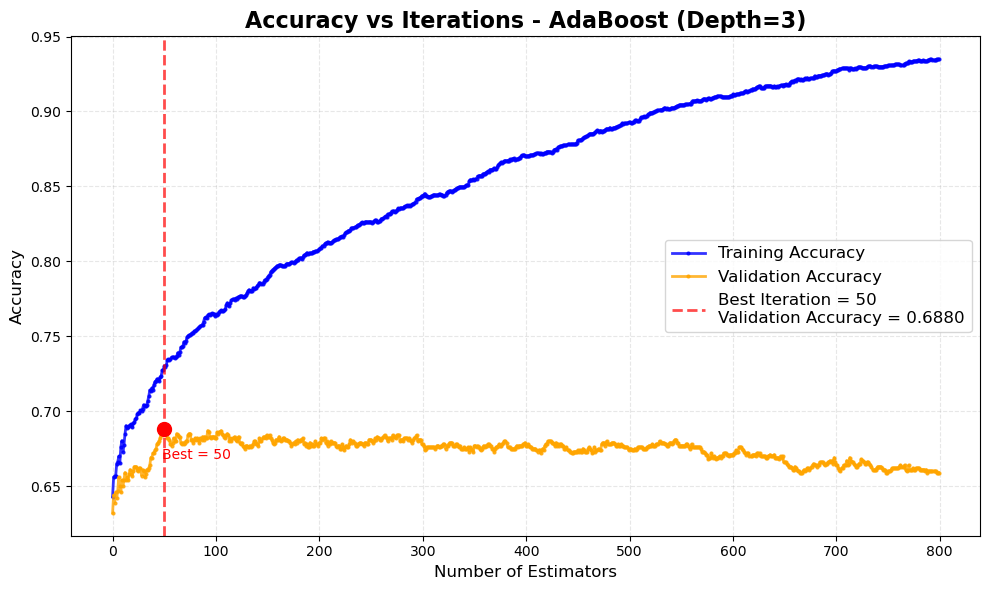

In [34]:
train_scores = list(ada.staged_score(X_train80, y_train80))
val_scores = list(ada.staged_score(X_val, y_val))
ada_best_n_estimators = np.array(val_scores).argmax() + 1


plt.figure(figsize=(10, 6))
plt.plot(train_scores, label='Training Accuracy', color='blue', linewidth=2, marker='o', markersize=2, alpha=0.8)
plt.plot(val_scores, label='Validation Accuracy', color='orange', linewidth=2, marker='o', markersize=2, alpha=0.8)
plt.axvline(ada_best_n_estimators, color='red', linestyle='--', alpha=0.7, linewidth=2, 
             label=f'Best Iteration = {ada_best_n_estimators}\nValidation Accuracy = {val_scores[ada_best_n_estimators-1]:.4f}')


plt.scatter(ada_best_n_estimators, val_scores[ada_best_n_estimators-1], color='red', s=100, zorder=5)  # Highlight the best point
plt.text(ada_best_n_estimators - 2, val_scores[ada_best_n_estimators-1] - 0.02,
         f'Best = {ada_best_n_estimators}', fontsize=10, color='red')


plt.xlabel('Number of Estimators', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title("Accuracy vs Iterations - AdaBoost (Depth=3)", fontsize=16, fontweight='bold')


plt.grid(alpha=0.3, linestyle='--')
plt.legend(fontsize=12)
plt.tight_layout()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.4** Repeat the plot above for a base learner with depths of 1, 2, 3, and 4. For easier comparison you should arrange your plots in a row. What trends do you see in the training and validation accuracies and how would you explain this behavior?

**NOTE:** It is okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_We notice that the training accuracy keeps increasing with more iterations, which makes sense because each new model learns from the mistakes of the previous one, so the accuracy naturally improves. However, as the depth of the base learner increases, the training accuracy gets even higher, and by depth-4, it almost reaches 1 at later iterations. But this trend doesn’t hold for validation accuracy. At depth-1, the validation accuracy improves steadily along with the training accuracy, but for higher depths, the validation accuracy peaks at a certain point and then starts to drop, while training accuracy keeps climbing. This happens because at depth-1, the model is simple and doesn’t overfit easily. As the depth increases, the complexity of the base model grows, making it harder to generalize, which is why the validation accuracy declines after a certain number of iterations—it’s overfitting. Another factor could be the presence of noise in the training data. Boosting focuses on fitting the residuals or misclassifications of previous models, so if there’s a lot of noise, the model might end up fitting to that noise over many iterations, leading to overfitting._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [35]:
max_depth = [1,2,3,4]
iterations = 800
lr = 0.05
train_acc = {0:[], 1:[], 2:[], 3:[]}
val_acc = {0:[], 1:[], 2:[], 3:[]}
best_iter = []

for i in range(len(max_depth)):
    ada_loop = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth=max_depth[i]),
                             n_estimators = iterations, 
                             learning_rate = lr,
                             random_state = 0,
                             algorithm = "SAMME.R")

    ada_loop.fit(X_train80, y_train80)
    train_acc[i] = list(ada_loop.staged_score(X_train80,y_train80))
    val_acc[i] = list(ada_loop.staged_score(X_val, y_val))
    best_iter.append(np.array(val_acc[i]).argmax() + 1)

c:\Users\fahja\micromamba\envs\cs109a\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\fahja\micromamba\envs\cs109a\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\fahja\micromamba\envs\cs109a\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\fahja\micromamba\envs\cs109a\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to ci

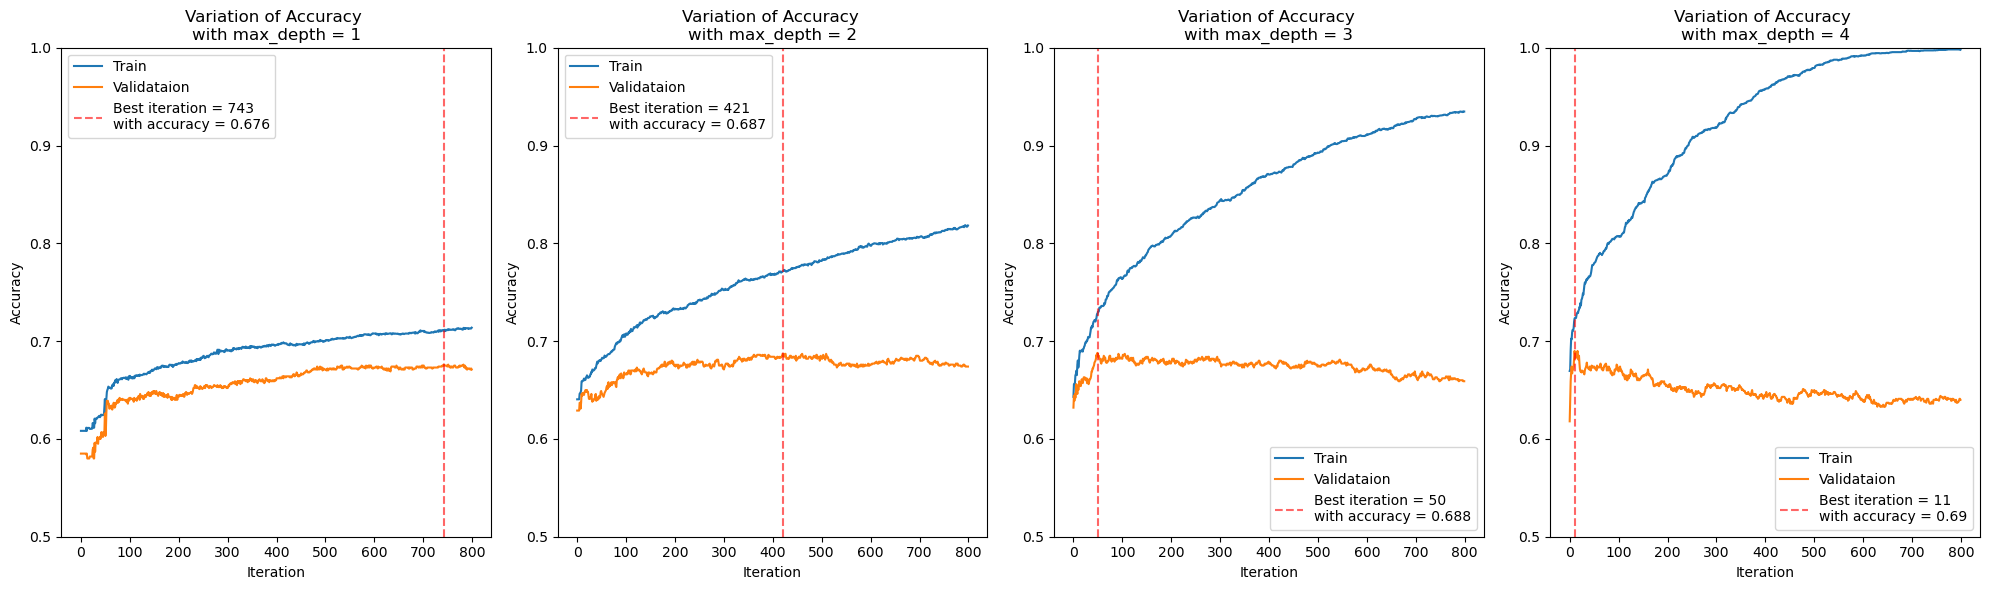

In [36]:
fig, ax = plt.subplots(1,4, figsize=(20,6))
ax = ax.ravel()
for i in range(len(max_depth)):
    ax[i].plot(train_acc[i],label='Train')
    ax[i].plot(val_acc[i],label='Validataion')
    ax[i].axvline(best_iter[i], color='red', alpha=0.6, linestyle='--', 
             label=f'Best iteration = {best_iter[i]} \nwith accuracy = {val_acc[i][best_iter[i]-1]}')
    ax[i].set_xlabel('Iteration')
    ax[i].set_ylabel('Accuracy')
    ax[i].set_ylim(0.50,1)
    ax[i].set_title(f"Variation of Accuracy \nwith max_depth = {max_depth[i]}")
    ax[i].legend()
    plt.tight_layout();

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.5** Based on the plots from Question 4.4, what combination of base learner depth and the number of iterations seems optimal and why?

**Note:** Feel free to make use of additional code to make your decision here if that is helpful. 
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_In boosting, depth-1 stumps are typically preferred for simplicity, but here they result in the lowest validation accuracy, requiring a high number of iterations, which makes them computationally expensive and suboptimal despite minimal overfitting. Depths 2, 3, and 4 achieve similar validation accuracies, with depth-4 performing best at just 11 iterations. However, validation accuracy for depth-4 drops significantly after the initial estimators, indicating overfitting due to its complexity. Depth-3 strikes a better balance, capturing complex boundaries while maintaining a smaller gap between training and validation accuracy compared to depth-2, suggesting less overfitting. Considering accuracy, generalization, and efficiency, depth-3 with 50 iterations is the most optimal choice._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [37]:
iter_val_max = []
train_val_max = []
val_max = []
for i in range(0,4):
    iter_val_max.append(np.argmax(val_acc[i])+1)
    val_max.append(val_acc[i][iter_val_max[i]-1])
    train_val_max.append(train_acc[i][iter_val_max[i]-1])

    
train_val_dict = {'Max Depth': max_depth, 
                  'Best Iteration': iter_val_max, 
                  'Train Accuracy': train_val_max, 
                  'Validation Accuracy': val_max,
                 'Train_Validation_Accuracy_Delta': [round(train_acc - test_acc,2) for train_acc, test_acc in zip(train_val_max,val_max)]}

train_val_df = pd.DataFrame(train_val_dict)

display(train_val_df)

,Max Depth,Best Iteration,Train Accuracy,Validation Accuracy,Train_Validation_Accuracy_Delta
0,1,743,0.71125,0.676,0.04
1,2,421,0.77125,0.687,0.08
2,3,50,0.72725,0.688,0.04
3,4,11,0.72325,0.690,0.03


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.6** Fit a final AdaBoostClassifier on the **entire train set** using the base learner depth and number of iterations you identified as optimal in the previous question. Keep the learning rate at 0.05 as before. Store the train and test accuracies in `ada_train_acc` and `ada_test_acc` respectively. How does the performance of this model compare with the performance of the ensemble methods you considered in Question 2 and Question 3?

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

**Model Comparison Q2,3,4**
| Question | Classifier                        | Training Accuracy | Test Accuracy |
|----------|-----------------------------------|-------------------|---------------|
| 2        | Bagging 55 depth-20 trees         | 0.9996            | 0.6786        |
| 3        | Random forest of 55 depth-20 trees| 1.0000            | 0.6922        |
| 4        | AdaBoost (depth=3, estimator=50)  | 0.7194            | 0.6998        |


_The AdaBoost model, employing depth-3 trees and 50 iterations, achieves a train accuracy of 0.7194 and a test accuracy of 0.6998. This represents an improvement over the Bagging model from Question 2 (train: 0.9996, test: 0.6786) and the Random Forest model from Question 3 (train: 1.0000, test: 0.6922)._

_When comparing these results, it is clear that AdaBoost performs better on the test data. The Bagging model (Q2) achieved a test accuracy of 0.6786, while the Random Forest (Q3) slightly improved upon this with a test accuracy of 0.6922. However, both are surpassed by AdaBoost’s test accuracy of 0.6998. This suggests that AdaBoost generalizes more effectively than the other models. Its use of shallow trees and iterative focus on previous errors helps maintain a balance between bias and variance. In contrast, the deeper trees of Bagging and Random Forest are more susceptible to overfitting, which can compromise performance on unseen data._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [38]:

ada_best = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), 
                           n_estimators= 50, 
                           learning_rate=lr,
                            random_state=0)
ada_best.fit(X_train, y_train)

ada_train_acc = ada_best.score(X_train, y_train)
ada_test_acc = ada_best.score(X_test, y_test)

c:\Users\fahja\micromamba\envs\cs109a\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [39]:
print(f"Ada Boost Train Accuracy: {ada_train_acc:.2%}")
print(f"Ada Boost Test Accuracy: {ada_test_acc:.2%}")

Ada Boost Train Accuracy: 71.94%
Ada Boost Test Accuracy: 69.98%


<!-- END QUESTION -->

**🌈 This concludes HW6. Thank you!**

[Return to contents](#contents)